# Imports

#### NOTE: change the root_dir path to your working dir path

In [1]:
# NOTE: change the root_dir path to your working dir path

import sys
root_dir = '/home/lpandey/Baby_Research/'
sys.path.append(root_dir)

from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
import torchvision.transforms as T
from torch.nn import functional as F
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)


import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from models.vit_contrastive import VisionTransformer, Backbone, LitClassifier, ViTConfigExtended, ViTConfig, configuration
from models.archs.resnet_2b import resnet_2blocks

/home/lpandey/Baby_Research/baby_env/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/lpandey/Baby_Research/baby_env/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/lpandey/Baby_Research/baby_env/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/lpandey/Baby_Research/baby_env/lib/python3.

In [2]:
# SELECT AND LOAD MODEL
def init_model(model, model_path=None):
    if model == 'pixels':
        model = nn.Flatten()
    elif model == 'simclr':
        model = SimCLR.load_from_checkpoint(model_path)
    elif model == 'supervised':
        model = resnet18(pretrained=True)
        model.fc = nn.Identity()
    elif model == 'untrained_r18_2b':
        model = resnet_2blocks(pretrained=False)
        model.fc = nn.Identity()
        print("Model selected - untrained resnet 18 : 2 blocks")
    elif model == 'vit':
        model = LitClassifier.load_from_checkpoint(model_path).backbone
        model.fc = nn.Identity()
    elif model == 'untrained_vit':
        configuration = ViTConfigExtended()
        configuration.num_attention_heads = configuration.num_hidden_layers = 9
        # print configuration parameters of ViT
        print('[INFO]  Image_size  :: ', configuration.image_size)
        print('[INFO]  Patch_size  :: ', configuration.patch_size)
        print('[INFO]  Num_classes  :: ', configuration.num_classes)
        print('[INFO]  Hidden_size  :: ', configuration.hidden_size)
        print('[INFO]  Intermediate_size  :: ', configuration.intermediate_size)
        print('[INFO]  Num_hidden_layers  :: ', configuration.num_hidden_layers)
        print('[INFO]  Num_attention_heads  :: ', configuration.num_attention_heads)
        
        # pass the configuration parameters to get backbone
        backbone = Backbone('vit', configuration)
        model = LitClassifier(backbone).backbone
        model.fc = nn.Identity()
    return model


In [3]:
def transform_img():
    transform = T.ToTensor()
    return transform

In [4]:
# returns the middle frame name, ex - output15.png

# find the front-view frame from the test folder
def get_frontViewFrame(data_dir, viewpoint_type='front'):
    if data_dir == '':
        raise ValueError("data_dir is empty. Please provide a valid path")
    
    frames = os.listdir(data_dir)
    
    # Sort the file names
    sorted_frames = sorted(frames, key=lambda x: int(x.split('_')[1].split('.png')[0]))
    #print(sorted_frames)
    
    # select the frame which has the front-view of the object
    if viewpoint_type == 'front':
        # Find the middle file
        middle_index = len(sorted_frames) // 2
        front_frame = sorted_frames[middle_index]
    else:
        raise ValueError("Invalid viewpoint type!!!")
    return front_frame

In [5]:
# custom sorting to get classes in the order - [circle, triangle, cone, brokenWall]
def custom_sort_key(item):
    custom_order = {
    'circle': 1,
    'triangle': 2,
    'cone': 3,
    'brokenWall': 4
    }
    parts = item.split('_')
    shape = parts[1]
    return (custom_order.get(shape, len(custom_order)), item)

In [6]:
# Image transform for GIM model
def get_transforms(eval=False, aug=None):
    trans = []

    if aug["randcrop"] and not eval:
        trans.append(transforms.RandomCrop(aug["randcrop"]))

    if aug["randcrop"] and eval:
        trans.append(transforms.CenterCrop(aug["randcrop"]))

    if aug["flip"] and not eval:
        trans.append(transforms.RandomHorizontalFlip())

    if aug["grayscale"]:
        trans.append(transforms.Grayscale())
        trans.append(transforms.ToTensor())
        trans.append(transforms.Normalize(mean=aug["bw_mean"], std=aug["bw_std"]))
#     elif aug["mean"]:
#         trans.append(transforms.ToTensor())
#         trans.append(transforms.Normalize(mean=aug["mean"], std=aug["std"]))
    else:
        trans.append(transforms.ToTensor())

    trans = transforms.Compose(trans)
    return trans

def default_transforms():
        """ Return default data transformation. """


        # define the augmentation types
        aug = {
            "stl10": {
                "randcrop": 64,
                "flip": False,
                "grayscale": False, # HARDCODED!!
                #"mean": [0.4313, 0.4156, 0.3663],  # values for train+unsupervised combined
                #"std": [0.2683, 0.2610, 0.2687],
                #"bw_mean": [0.4120],  # values for train+unsupervised combined
                #"bw_std": [0.2570],
            }  # values for labeled train set: mean [0.4469, 0.4400, 0.4069], std [0.2603, 0.2566, 0.2713]
        }

        # define train transforms
        transform_train = transforms.Compose(
            [get_transforms(eval=False, aug=aug["stl10"])]
        )

        # define val transforms
        transform_valid = transforms.Compose(
            [get_transforms(eval=True, aug=aug["stl10"])]
        )

        return transform_train, transform_valid
    
_, val_transform = default_transforms()

In [7]:
def get_testImages(data_dir,viewpoint_type='front', transform='non_GIM'):
    '''
    args:
    data_dir :: path to test dataset 
    viewpoint_type :: 'front' will select the middle frames from the folder to get the front view of the object
    '''
    # intialize transform
    if transform == 'non_GIM':
        print("transform selected: non_GIM")
        transform = transform_img()
    else:
        print("transform selected: GIM")
        transform = val_transform
    # store final transformed images in a list
    test_frames = []
    # 16 different visual binding classes, yellow circle, purple triangle,....
    classes = os.listdir(data_dir)
    # sort the classes
    sorted_classes = sorted(classes, key=custom_sort_key)

    print("The rows and cols in the matrix will be in this order ::")
    for cls in sorted_classes:
        print(data_dir+cls)
        frame = get_frontViewFrame(data_dir+cls)
        # transform image
        img = Image.open(data_dir+cls+"/"+frame)
        img_transformed = transform(img).unsqueeze(0)
        test_frames.append(img_transformed)
    return test_frames

In [8]:
test_frames = get_testImages('/data/lpandey/wood14_binding/testing/object1_separated/', transform='non_GIM')
len(test_frames)

transform selected: non_GIM
The rows and cols in the matrix will be in this order ::
/data/lpandey/wood14_binding/testing/object1_separated/green_circle
/data/lpandey/wood14_binding/testing/object1_separated/purple_circle
/data/lpandey/wood14_binding/testing/object1_separated/red_circle
/data/lpandey/wood14_binding/testing/object1_separated/yellow_circle
/data/lpandey/wood14_binding/testing/object1_separated/green_triangle
/data/lpandey/wood14_binding/testing/object1_separated/purple_triangle
/data/lpandey/wood14_binding/testing/object1_separated/red_triangle
/data/lpandey/wood14_binding/testing/object1_separated/yellow_triangle
/data/lpandey/wood14_binding/testing/object1_separated/green_cone
/data/lpandey/wood14_binding/testing/object1_separated/purple_cone
/data/lpandey/wood14_binding/testing/object1_separated/red_cone
/data/lpandey/wood14_binding/testing/object1_separated/yellow_cone
/data/lpandey/wood14_binding/testing/object1_separated/green_brokenWall
/data/lpandey/wood14_bindin

16

In [9]:
test_frames[3].shape

torch.Size([1, 3, 64, 64])

In [10]:
# Get encoder features - 

# LOAD A TRAINED MODEL FOR EVALUATION - 
model_path = '/data/lpandey/LOGS/VIT_Time/Eyeball_Project/paper_HumanAdults/UTAustinEgocentric/Exp2_IndividualAugmentation/Exp2_ColorJitterAugmentation/ViT9H/video3/version_2/checkpoints/epoch=4-step=2815.ckpt'
model = init_model(model="vit",model_path=model_path)

# LOAD AN UNTRAINED MODEL FOR EVALUATION - 
#model = init_model(model="untrained_vit")

# extract features and store it in a list - 
model.eval()
    
# Extact features.
all_features = []

for x in tqdm(test_frames):
    with torch.no_grad():
        feature = model(x)
        all_features.append(feature)

#all_features = torch.cat(all_features)

# Normalize features.
all_features = torch.cat(all_features) - torch.cat(all_features).mean(dim=0)

print(all_features.shape)

/home/lpandey/Baby_Research/baby_env/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.88it/s]

torch.Size([16, 512])


In [11]:
# Create Similarity Matrix
similarity_matrix = F.cosine_similarity(all_features.unsqueeze(1), all_features.unsqueeze(0), dim=2).cpu().numpy()
similarity_matrix = np.round(similarity_matrix,2)
similarity_matrix

array([[ 1.  ,  0.85,  0.63,  0.62, -0.43, -0.57, -0.59, -0.65,  0.25,
         0.08, -0.02, -0.23, -0.19, -0.39, -0.53, -0.65],
       [ 0.85,  1.  ,  0.87,  0.85, -0.7 , -0.71, -0.71, -0.79,  0.01,
         0.05,  0.18, -0.05, -0.41, -0.32, -0.25, -0.41],
       [ 0.63,  0.87,  1.  ,  0.98, -0.75, -0.71, -0.63, -0.76, -0.2 ,
        -0.09,  0.36,  0.08, -0.58, -0.41, -0.  , -0.25],
       [ 0.62,  0.85,  0.98,  1.  , -0.76, -0.72, -0.65, -0.74, -0.16,
        -0.05,  0.41,  0.18, -0.61, -0.5 , -0.07, -0.25],
       [-0.43, -0.7 , -0.75, -0.76,  1.  ,  0.95,  0.91,  0.91, -0.26,
        -0.45, -0.73, -0.56,  0.31,  0.13, -0.19, -0.11],
       [-0.57, -0.71, -0.71, -0.72,  0.95,  1.  ,  0.95,  0.95, -0.42,
        -0.5 , -0.68, -0.49,  0.17,  0.15, -0.08,  0.  ],
       [-0.59, -0.71, -0.63, -0.65,  0.91,  0.95,  1.  ,  0.95, -0.5 ,
        -0.59, -0.64, -0.5 ,  0.11,  0.07,  0.02,  0.05],
       [-0.65, -0.79, -0.76, -0.74,  0.91,  0.95,  0.95,  1.  , -0.36,
        -0.43, -0.58, -0.3

In [12]:
# Convert the similarity matrix to a DataFrame
df = pd.DataFrame(similarity_matrix)

# Save the DataFrame to a CSV file
df.to_csv("/data/lpandey/LOGS/dummy.csv", index=False, header=False)

/home/lpandey/Baby_Research/baby_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


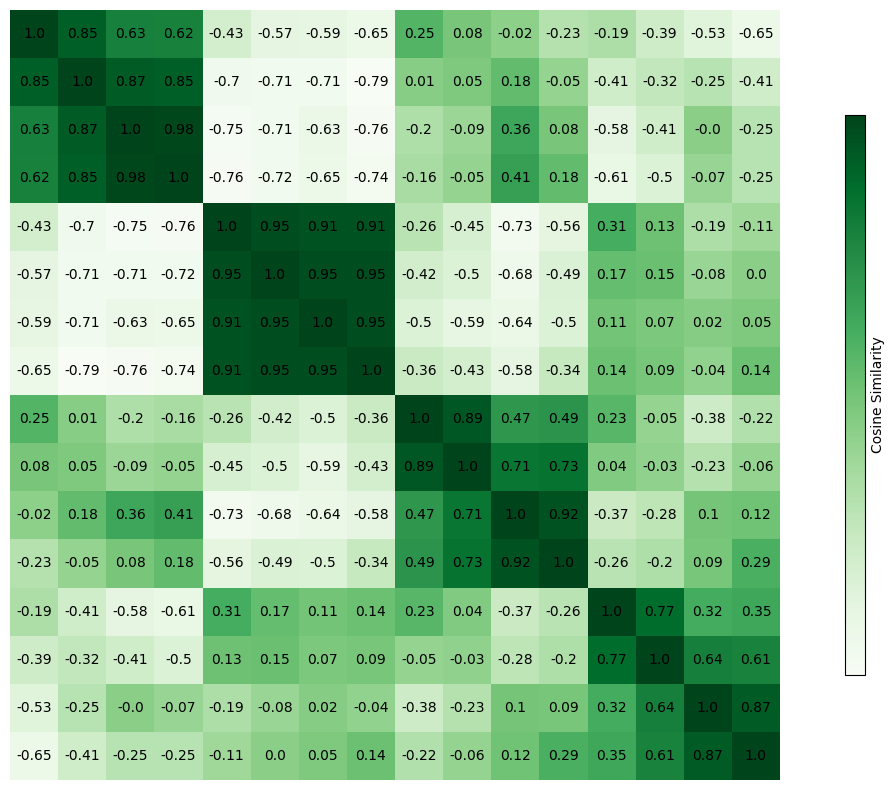

In [14]:
# CODE FOR A COLOR-CODED GRID
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["figure.autolayout"] = True

# Determine the min and max values in the matrix
min_val = np.min(similarity_matrix)
max_val = np.max(similarity_matrix)

# pos_cmap = plt.cm.get_cmap('Greens')
# neg_cmap = plt.cm.get_cmap('Oranges')


fig, ax = plt.subplots()


# cmap_limits = np.max(np.abs(similarity_matrix))
cmap_limits = max(abs(min_val), max_val)
#cmap = plt.cm.get_cmap('Greens')
cmap = plt.cm.Greens
# Show all ticks and label them with the respective list entries
x_axis = ['green_circle', 'purple_circle', 'red_circle', 'yellow_circle', 
          'green_triangle', 'purple_triangle','red_triangle', 'yellow_triangle', 
          'green_cone', 'purple_cone', 'red_cone', 'yellow_cone',
           'green_brokenWall', 'purple_brokenWall', 'red_brokenWall', 'yellow_brokenWall']

y_axis = ['green_circle', 'purple_circle', 'red_circle', 'yellow_circle', 
          'green_triangle', 'purple_triangle','red_triangle', 'yellow_triangle', 
          'green_cone', 'purple_cone', 'red_cone', 'yellow_cone',
           'green_brokenWall', 'purple_brokenWall', 'red_brokenWall', 'yellow_brokenWall']


for i in range(16):
    for j in range(16):
        c = similarity_matrix[j, i]
        color = cmap((c - min_val) / (max_val - min_val))          
        ax.add_patch(plt.Rectangle((i - 0.5, j - 0.5), 1, 1, facecolor=color))
        ax.text(i, j, str(c), va='center', ha='center', color='black', fontsize=10)
        
ax.set_xticks(np.arange(len(x_axis)))
ax.set_yticks(np.arange(len(y_axis)))
ax.set_xticklabels(x_axis)
ax.set_yticklabels(y_axis)

ax.matshow(similarity_matrix, cmap='Greens')
plt.axis('off')

# Create a color bar legend
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax)
cb.set_label('Cosine Similarity')
cb.set_ticks([])  # Remove ticks and labels

plt.show()